# 05_arima_sarima

## Importando bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import plotly.graph_objects as go
import plotly.io as pio

import numpy as np


## Carregando os dados

In [2]:
# Carregar os dados (exemplo simplificado)
df = pd.read_csv('../data/raw/train.csv', parse_dates=['Date'])
df = df[df['Store'] == 1]  # Foco em uma loja específica
df = df[df['Sales'] > 0]
df.set_index('Date', inplace=True)
df = df.asfreq('D')

C:\Users\heitor\AppData\Local\Temp\ipykernel_19056\2713475017.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/train.csv', parse_dates=['Date'])


## Processamento

In [3]:
# Preenchendo valores ausentes
df['Sales'] = df['Sales'].interpolate()

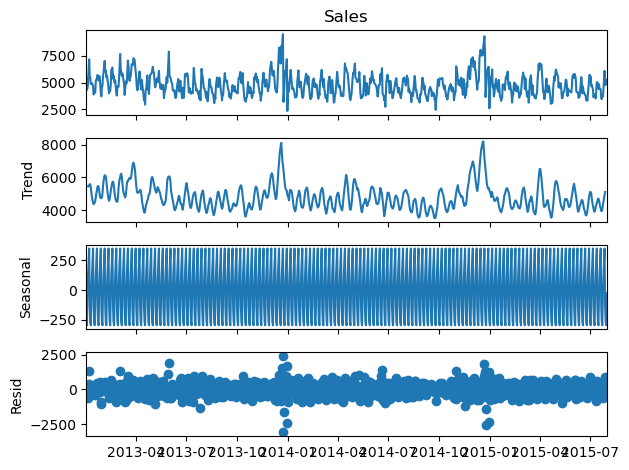

In [4]:
# Decomposição sazonal
sm.tsa.seasonal_decompose(df['Sales'], model='additive').plot()
plt.show()

In [5]:
# Modelo SARIMA (ordens podem ser ajustadas após auto_arima ou AIC tests)
model = SARIMAX(df['Sales'], order=(3,1,1), seasonal_order=(1,1,1,7))
results = model.fit()

c:\Users\heitor\anaconda3\envs\cases_data_science\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 🔧 Ajuste de Parâmetros do SARIMAX

### 📌 Estrutura dos Parâmetros

* `order=(p, d, q)`
  * **p** : número de defasagens autorregressivas (AR)
  * **d** : grau de diferenciação (para tornar a série estacionária)
  * **q** : número de defasagens da média móvel (MA)
* `seasonal_order=(P, D, Q, S)`
  * **P, D, Q** : equivalentes aos parâmetros AR, I, MA, mas para a **parte sazonal**
  * **S** : periodicidade da sazonalidade (ex: 7 para semanal, 12 para mensal)

In [6]:
# Previsão para o mesmo período de test.csv
test = pd.read_csv('../data/raw/test.csv', parse_dates=['Date'])
display(test.head(), test.shape)
test_store1 = test[test['Store'] == 1].set_index('Date')
test_store1 = test_store1.asfreq('D')
print(len(test_store1))
forecast = results.get_forecast(steps=len(test_store1))
conf_int = forecast.conf_int()
predicted_mean = forecast.predicted_mean

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


(41088, 8)

48


In [7]:
# Previsão para o período de treino (ajuste os parâmetros conforme seu modelo)
train_pred = results.predict(start=df.index[0], end=df.index[-1])

# Valores reais do treino
y_true_train = df['Sales']
y_pred_train = train_pred

# Avaliação do desempenho do modelo de previsão
rmse = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
mae = mean_absolute_error(y_true_train, y_pred_train)
mape = mean_absolute_percentage_error(y_true_train, y_pred_train)

print(f"📉 RMSE (Root Mean Squared Error) - Treino: {rmse:.2f}")
print(f"📉 MAE  (Mean Absolute Error) - Treino: {mae:.2f}")
print(f"📉 MAPE (Mean Absolute Percentage Error) - Treino: {mape:.2%}")

📉 RMSE (Root Mean Squared Error) - Treino: 633.06
📉 MAE  (Mean Absolute Error) - Treino: 453.90
📉 MAPE (Mean Absolute Percentage Error) - Treino: 9.78%


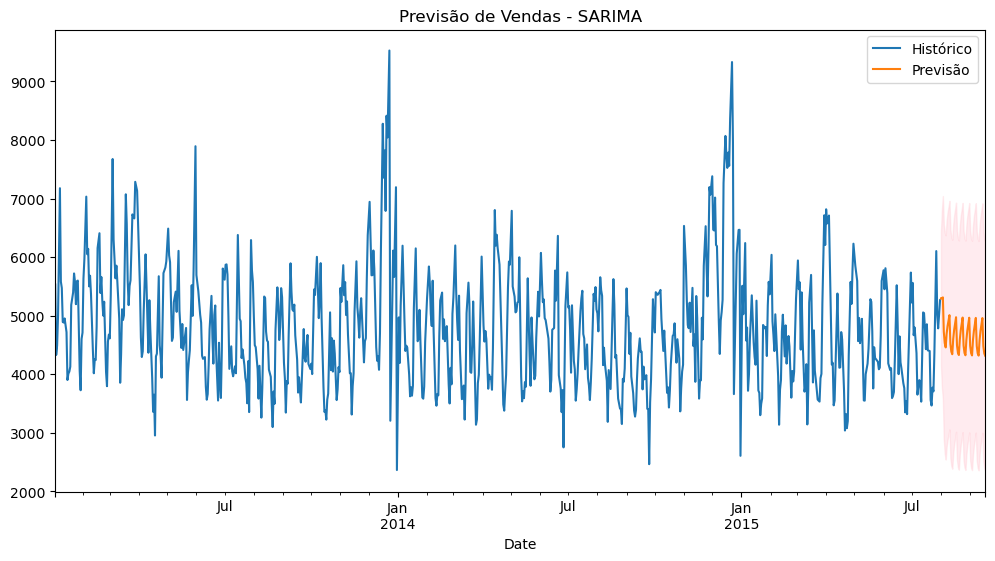

In [8]:
# Avaliação (se dados reais disponíveis)
# Aqui usamos os valores reais de test.csv se estiverem disponíveis
# if 'Sales' in test_store1.columns:
#     y_true = test_store1['Sales'].dropna()
#     y_pred = predicted_mean.loc[y_true.index]
#     rmse = mean_squared_error(y_true, y_pred, squared=False)
#     mae = mean_absolute_error(y_true, y_pred)
#     print(f'RMSE SARIMA: {rmse:.2f}')
#     print(f'MAE SARIMA: {mae:.2f}')

# Visualização
plt.figure(figsize=(12, 6))
df['Sales'].plot(label='Histórico')
predicted_mean.plot(label='Previsão')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Previsão de Vendas - SARIMA')
plt.show()

In [9]:
# Cria a figura
fig = go.Figure()

# Série histórica
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Sales'],
    mode='lines',
    name='Histórico',
    line=dict(color='blue')
))

# Previsão no treino
fig.add_trace(go.Scatter(
    x=df.index,
    y=y_pred_train,
    mode='lines',
    name='Previsto (Treino)',
    line=dict(color='orange', dash='dot')
))

# Previsão
fig.add_trace(go.Scatter(
    x=predicted_mean.index,
    y=predicted_mean,
    mode='lines',
    name='Previsão'
))

# Intervalo de confiança - limite inferior
fig.add_trace(go.Scatter(
    x=conf_int.index,
    y=conf_int.iloc[:, 0],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    name='Lower Bound'
))

# Intervalo de confiança - limite superior e preenchimento
fig.add_trace(go.Scatter(
    x=conf_int.index,
    y=conf_int.iloc[:, 1],
    mode='lines',
    line=dict(width=0),
    fill='tonexty',  # Preenche a área entre os dois traces
    fillcolor='rgba(255, 192, 203, 0.3)',  # rosa claro
    showlegend=True,
    name='Intervalo de Confiança'
))

# Layout
fig.update_layout(
    title='Previsão de Vendas - SARIMA',
    xaxis_title='Data',
    yaxis_title='Vendas',
    template='plotly_white',
    width=1000,
    height=500
)

# Salva como PNG (requer kaleido instalado)
fig.write_image("../reports/figures/sarima_forecast.png")

# Exibe no notebook
fig.show()
